# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

### Ring parameters

In [2]:
N = 8  # number of transmons
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (5, 4), (6, 5), (7, 6), (0, 7)]  # edges
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

In [21]:
from freq_allocation.parsing import *
# parse the csd
G = parse_csv("../solutions/juin/")
architecture = "CR" 

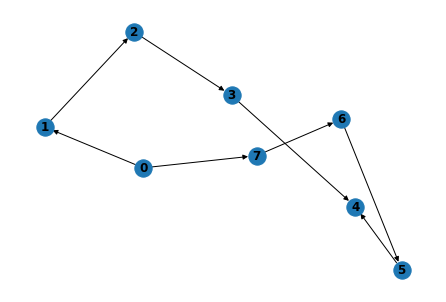

In [22]:
G.plot()

### Constructing a FrequencyGraph object

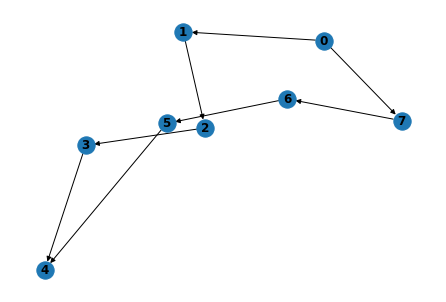

In [3]:
G = FrequencyGraph(edges=edges, cz=cz)
G.plot()

In [4]:
G.cz

False

In [23]:
#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

## Optimization of the frequency

### optimization parameters

In [6]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

### Optimization

In [7]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
optimizer.second_pass()
result = optimizer.third_pass()

### Adding the results to the frequencyGraph

In [33]:
# manually adding the frequencyes and the drives
freqs = np.array([ 5.63, 5.55, 5.40, 5.25, 5.05, 5.15, 5.3, 5.43])
freqs = np.array([ 5.794, 5.659, 5.478, 5.297, 5.115, 5.240, 5.421, 5.603])
freqs = {k: freqs[k] for k in range(8)}
anharms = {k: -0.310 for k in range(8)}
drives =  {e: freqs[e[1]] for e in G.edges}

In [9]:
drives

{(0, 1): 5.659,
 (0, 7): 5.603,
 (1, 2): 5.478,
 (2, 3): 5.297,
 (3, 4): 5.115,
 (5, 4): 5.115,
 (6, 5): 5.24,
 (7, 6): 5.421}

In [9]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)

The drive frequency are CR compatible


In [10]:
print(G.check_solution(d_dict, cstr=cstr_key))

True


[]

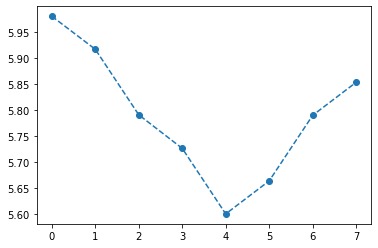

In [24]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.plot()

## Yield of the design

Qubit collisions:
yield   = 0.1517
average = 2.8755


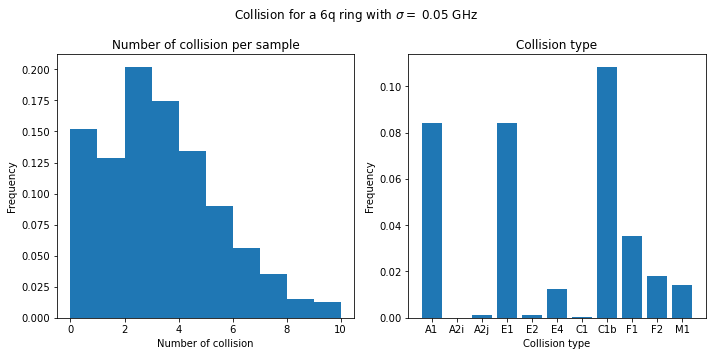

In [25]:
# parametrization
Nsamples = 10000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

### Collision type distribution

### Collision spatial distribution

In [26]:
x = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
xm = [(x[i] + x[i+1])/2 for i in range(len(x)-1)]

Text(0.5, 0, 'Collision type')

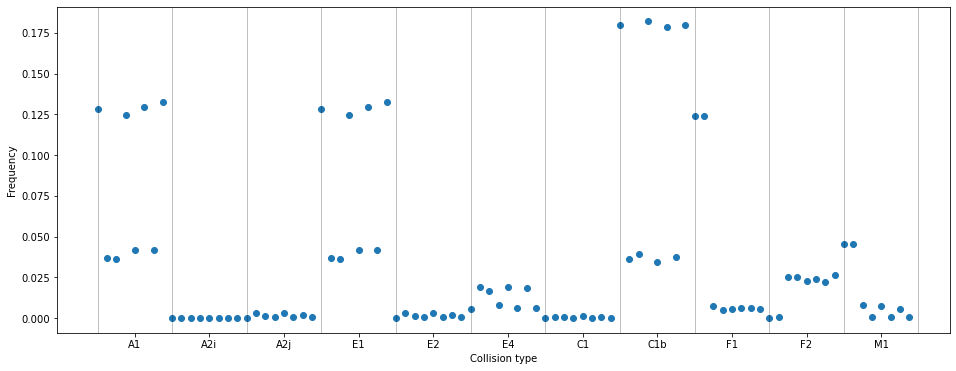

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.sum(~np.array(c), axis=1)/Nsamples, 'o')
for xx in x:
    ax.axvline(xx, color='k', linewidth=0.5, alpha = 0.5)
ax.set_xticks(xm);
ax.set_xticklabels(constraints)

ax.set_ylabel('Frequency')
ax.set_xlabel("Collision type")

### Collision vs std of the frequencies

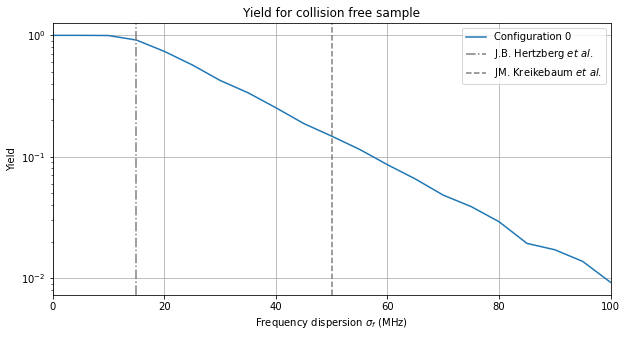

In [28]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 10000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [29]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_2_yield.npy',data)

In [30]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]
data_CZ = np.load('ring_8t_CR_2_yield.npy', allow_pickle=True)[()]

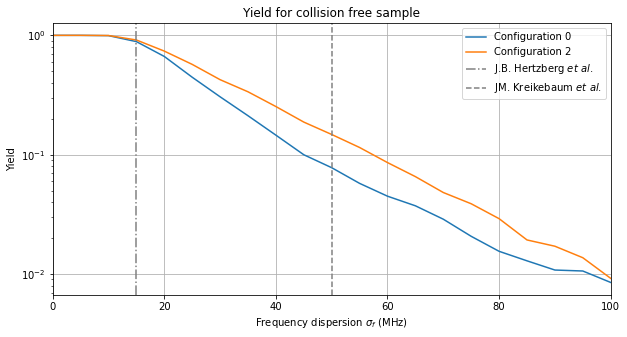

In [32]:
fig, ax = plt.subplots( figsize=(10, 5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data_CZ["sigma"]
y_cz = data_CZ["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'Configuration {0}')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'Configuration {2}')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [53]:
data_CR

array({'sigma': array([0.     , 0.00125, 0.0025 , 0.00375, 0.005  , 0.00625, 0.0075 ,
       0.00875, 0.01   , 0.01125, 0.0125 , 0.01375, 0.015  , 0.01625,
       0.0175 , 0.01875, 0.02   , 0.02125, 0.0225 , 0.02375, 0.025  ,
       0.02625, 0.0275 , 0.02875, 0.03   , 0.03125, 0.0325 , 0.03375,
       0.035  , 0.03625, 0.0375 , 0.03875, 0.04   , 0.04125, 0.0425 ,
       0.04375, 0.045  , 0.04625, 0.0475 , 0.04875, 0.05   , 0.05125,
       0.0525 , 0.05375, 0.055  , 0.05625, 0.0575 , 0.05875, 0.06   ,
       0.06125, 0.0625 , 0.06375, 0.065  , 0.06625, 0.0675 , 0.06875,
       0.07   , 0.07125, 0.0725 , 0.07375, 0.075  , 0.07625, 0.0775 ,
       0.07875, 0.08   , 0.08125, 0.0825 , 0.08375, 0.085  , 0.08625,
       0.0875 , 0.08875, 0.09   , 0.09125, 0.0925 , 0.09375, 0.095  ,
       0.09625, 0.0975 , 0.09875, 0.1    ]), 'collisions': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 8, 5, ..., 3, 8, 3],
       [5, 4, 4

In [76]:
ord?

Signature: ord(c, /)
Docstring: Return the Unicode code point for a one-character string.
Type:      builtin_function_or_method
